In [1]:
import numpy as np
from scipy import signal
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import optimize
from scipy.interpolate import interp1d

$\frac{dy}{dt}=\frac{-y(t)}{\tau}+\frac{K_p *u*(t-\theta_p)}{\tau}$

In [2]:
def FOPDTmodel(output_value, t, params, t_vector, input_vector, output0):
    
    """First order model with time delay. Also called 
       First order plus dead time (FOPDT)

    Args:
        output_value (float): the output (see equation above) for the step (delta t)
        t (float): time value to be used to calculate dy/dt
        params (list): parameters of the model:
            params[0] (float): Kp - gain
            params[1] (float): tau - time constant
            params[2] (float): theta - dead time
        t_vector (np.array of float): time vector
        input_vector (np.array of float): the input vector matching the time vector
        output0 (float): initial value for the output at time zero

    Returns:
        float: dy/dy calculated for the conditions


    """
    ############################################################################
    ## model parameters sequence is defined by "odeint"                        #
    ## it clashes with the "minimize" function below, so could NOT harmonize.  #
    ############################################################################
    
    #ideas from: https://apmonitor.com/pdc/index.php/Main/FirstOrderOptimization
    
    #print('initial conditions: ',init_condition)
    #print('t: ', t, t_vector[-1])
    #print('params: ', params)
    #print('t_vector: ', t_vector)
    #print('input_vec: ', input_vector)
    #print('output_vec: ', output_vector)
    Kp = params[0]
    tau = params[1]
    theta = params[2]

    input0 = input_vector[0]
    
    input_interp = interp1d(t_vector, input_vector)
    if ((t-theta)<= 0) or (t<0.0):
        input_value = input_interp(0.0)
    elif ((t-theta)> t_vector[-1]) or (t>t_vector[-1]):
        input_value = input_vector[-1]
    else:
        input_value = input_interp(t-theta)        
    #dydt = (-(init_cond-output_value)/tau)+(Kp*(input_value)*(t-theta))/tau
    ##dydt = (-(output_value-init_cond)+Kp*(input_value-input0))/tau
    dydt = (-(output_value-output0) + Kp * (input_value-input0))/tau
    return dydt

In [3]:
def integrate_model(model, step_output_value, params, t_vector, input_vector, output_vector):
    """Integrator function - this function's intent is to return the integral of dy/dt
       over the whole time vector

    Args:
        model (function object): the function that returns dy/dt (the model)
        step_output_value (float): the output for the first step
        params (list): parameters of the model:
            params[0] (float): Kp - gain
            params[1] (float): tau - time constant
            params[2] (float): theta - dead time
        t_vector (np.array of float): time vector
        input_vector (np.array of float): the input vector matching the time vector
        output0 (float): initial value for the output at time zero

    Returns:
        np.array of floats: for each time in time vector, return the model output, integrated


    """
    # define the collector for each integration step
    model_output = np.zeros(len(t_vector))
    for i in range(len(t_vector)-1):
        ts = [t_vector[i], t_vector[i+1]]
        step_args_list = [list(params), t_vector, input_vector, output_vector[0]]
        step_args = tuple(step_args_list)
        #print(step_args)
        #init_cond, t, params, t_vector, input_vector, output_vector
        step_output = odeint(model, step_output_value, ts, args=step_args)
        model_output[i+1] = step_output[1]
        step_output_value = step_output[1]
    return model_output

time vector length: 141, input vector length: 141
single integral step check: 0.0


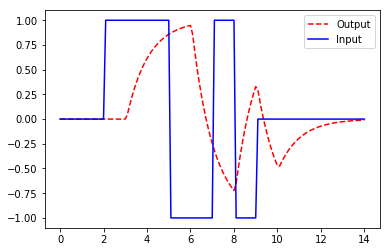

In [5]:
# unit test

# lets try a 3-2-1-1 input
# so this is going to be a zero-high-low-high-etc vector
input_shape = [2,3,2,1,1,5]
input_amplitudes = [0,1,-1,1,-1,0]
# if you prefer a step input, use the shape below
#input_shape = [2,3]
#input_amplitudes = [0,1]

time_step = 0.1

u = 0
previous_t = 0
current_t = 0

# generate the input vector
for i in range(len(input_shape)):
    current_t = current_t + input_shape[i]
    u = np.append(u, np.ones((int((current_t-previous_t)/time_step)))*input_amplitudes[i])
    previous_t = previous_t + input_shape[i]

# we need a time vector of the same length
t_vector = np.linspace(0, sum(input_shape), len(u))
print('time vector length: {}, input vector length: {}'.format(len(t_vector), len(u)))


input_vector = u
output_vector = u*2 #for now
Kp_model = 1
tau_model = 1
theta_model = 1

t=3
params = [Kp_model, tau_model, theta_model]

init_cond = output_vector[0]

dy = FOPDTmodel(init_cond, t, params, t_vector, input_vector, output_vector[0])
print('single integral step check: {}'.format(dy))


init_cond = output_vector[0]

sim_data = integrate_model(FOPDTmodel, init_cond, params, t_vector, input_vector, output_vector)
plt.figure(6)
plt.plot(t_vector,sim_data,'r--', label='Output')
plt.plot(t_vector, input_vector, 'b-', label='Input')
plt.legend(loc='best')

In [6]:
# Cost function definition: squares of the errors
def lq_functional(est_param, model, init_condition, t_vector, input_vector, output_vector):
    """Cost function - returns the squared of the differences between model and measured output data

    Args:
        est_params (list): parameters of the model:
            params[0] (float): Kp - gain
            params[1] (float): tau - time constant
            params[2] (float): theta - dead time
        model (function object): the function that returns dy/dt (the model)
        init_condition (float): the output for the first step (initial output at time zero)
        t_vector (np.array of float): time vector
        input_vector (np.array of float): the input vector matching the time vector
        output_vector (np.array of float): measured output vector

    Returns:
        float: sum of the squared difference sum(model - measured output)**2


    """
    Kp_est = est_param[0]
    tau_est = est_param[1]
    theta_est = est_param[2]
    params = [Kp_est, tau_est, theta_est]
    calc_output = integrate_model(model, init_condition, params, t_vector, input_vector, output_vector)
    err = 0.0
    for i in range(len(t_vector)-1):
        err = err + (calc_output[i] - output_vector[i])**2
    return err

Calulated cost function, no noise: 74.57597593765388
Calulated cost function, with noise: 100.04831592252712


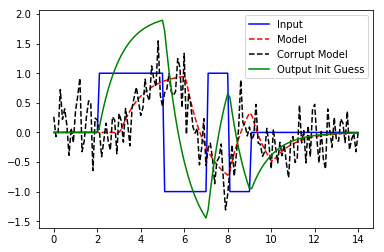

In [7]:
# unit test - cost function
# so now I can 'guess' some values and calculate the error
Kp_est = 2
tau_est = 1
theta_est = 0

init_condition = sim_data[0]


est_param = [Kp_est, tau_est, theta_est]

cost = lq_functional(est_param, FOPDTmodel, init_condition, t_vector, input_vector, sim_data)
print('Calulated cost function, no noise: {}'.format(cost))

# Add noise to data so that we can check if we can identify the parameters

sim_data_corrupted = np.random.normal(sim_data,0.3)
cost = lq_functional(est_param, FOPDTmodel, init_condition, t_vector, input_vector, sim_data_corrupted)
print('Calulated cost function, with noise: {}'.format(cost))

initial_fit_data = integrate_model(FOPDTmodel, init_cond, est_param, t_vector, input_vector, output_vector)

plt.figure(6)

plt.plot(t_vector, input_vector, 'b-', label='Input')
plt.plot(t_vector,sim_data,'r--', label='Model')
plt.plot(t_vector,sim_data_corrupted,'k--', label='Corrupt Model')
plt.plot(t_vector, initial_fit_data, 'g-', label='Output Init Guess')
plt.legend(loc='best')

In [8]:
# Parameter Identification - minimize the functional
x0 = [Kp_est, tau_est, theta_est]
res = optimize.minimize(lq_functional, x0, args=(FOPDTmodel, init_condition, t_vector, input_vector, sim_data))

Original Kp: 1, Estimated Kp: 1.000, delta: 2.68E-05
Original Tau: 1, Estimated Tau: 1.000, delta: 3.39E-05
Original Theta: 1, Estimated Theta: 1.000, delta: -6.01E-06


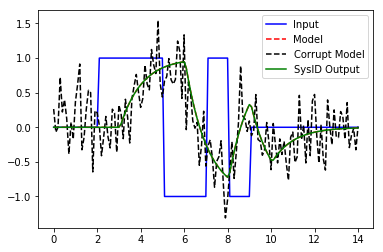

In [9]:
# results
print('Original Kp: {}, Estimated Kp: {:.3f}, delta: {:.2E}'.format(Kp_model, res.x[0], Kp_model-res.x[0]))
print('Original Tau: {}, Estimated Tau: {:.3f}, delta: {:.2E}'.format(tau_model, res.x[1], tau_model-res.x[1]))
print('Original Theta: {}, Estimated Theta: {:.3f}, delta: {:.2E}'.format(theta_model, res.x[2], theta_model-res.x[2]))
params = res.x

model_fit_data = integrate_model(FOPDTmodel, init_cond, params, t_vector, input_vector, output_vector)
plt.figure(6)

plt.plot(t_vector, input_vector, 'b-', label='Input')
plt.plot(t_vector,sim_data,'r--', label='Model')
plt.plot(t_vector,sim_data_corrupted,'k--', label='Corrupt Model')
plt.plot(t_vector, model_fit_data, 'g-', label='SysID Output')
plt.legend(loc='best')

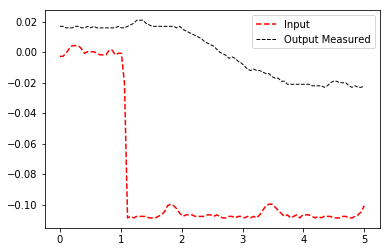

In [10]:
#Real parameter ID - golden servo data

import pandas as pd
data_in = pd.read_csv('golden_servo_step.csv')
sampling_rate = 20
data_in = data_in.iloc[100:200,:]
# let's remove the means
data_in['input'] = data_in['input'] - data_in.mean()[0]
data_in['output'] = data_in['output'] - data_in.mean()[1]
# and zero the initial input
init_raw_input_avrg = data_in['input'][:5].mean()
data_in['input'] = data_in['input'] - init_raw_input_avrg
t_vector = np.linspace(0, int(len(data_in)/sampling_rate), len(data_in))
input_vector = data_in.iloc[:,0].values
output_vector = data_in.iloc[:,1].values
plt.figure(5)
plt.plot(t_vector,input_vector,'r--', label='Input')
plt.plot(t_vector,output_vector,'k--', linewidth=1, label='Output Measured')
plt.legend(loc='best')

In [11]:
x0 = [0.5, 1, 1]
init_cond = data_in['output'][:10].mean()
res = optimize.minimize(lq_functional, x0, args=(FOPDTmodel, init_condition, t_vector, input_vector, output_vector))

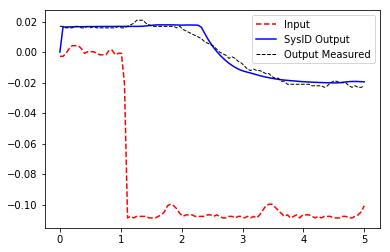

In [13]:
# plot
params = res.x
#params = [0.4, 1, 1]
calc_yc = integrate_model(FOPDTmodel, init_cond, params, t_vector, input_vector, output_vector)
plt.figure(5)
plt.plot(t_vector,input_vector,'r--', label='Input')
plt.plot(t_vector,calc_yc,'b-', label='SysID Output')
plt.plot(t_vector,output_vector,'k--', linewidth=1, label='Output Measured')
plt.legend(loc='best')

In [14]:
res

      fun: 0.0019626946432488644
 hess_inv: array([[  2.18820913,   7.51853703,  -0.42884846],
       [  7.51853703,  71.58432156, -28.52741985],
       [ -0.42884846, -28.52741985,  40.70858745]])
      jac: array([ 6.74277544e-07, -6.49131835e-07, -2.27452256e-06])
  message: 'Optimization terminated successfully.'
     nfev: 100
      nit: 16
     njev: 20
   status: 0
  success: True
        x: array([0.35557428, 0.44073721, 1.23371004])